In [583]:
import numpy as np
import pyedflib

import pandas as pd
from gtda.time_series import SingleTakensEmbedding
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import PersistenceEntropy, Amplitude, NumberOfPoints, ComplexPolynomial, PersistenceLandscape, HeatKernel, Silhouette, BettiCurve, PairwiseDistance, ForgetDimension
from sklearn.model_selection import train_test_split, KFold
import random

# Choose EEG or EMG

In [584]:
# Choose if you want to look at EEG or EMG data

data_type = "EEG" # Does not have an effect yet, will be added later when processing anesthesia data
data_type = "EMG"

In [585]:
subject = "298"


In [586]:
label_list = [1, 2, 3, 4, 5, 7]


# Import Data

In [587]:
# EEG/EMG data

def read_edf_file(file_path):
    """
    Reads an .edf file and returns the EEG and EMG streams as pandas DataFrames.
    """
    f = pyedflib.EdfReader(file_path)

    # Assuming the EEG channel is the first channel and EMG is the second channel
    eeg_signal = f.readSignal(0)
    emg_signal = f.readSignal(1)

    # Extract the channel names for the DataFrame
    eeg_channel_name = f.getSignalLabels()[0]
    emg_channel_name = f.getSignalLabels()[1]

    # Get the sample frequency
    sample_frequency = f.getSampleFrequency(0)  # Assuming both streams have the same frequency

    # Calculate the timestamps for the samples
    n_samples = min(len(eeg_signal), len(emg_signal))
    time = [i / sample_frequency for i in range(n_samples)]

    # Create pandas DataFrame
    df = pd.DataFrame({
        'Time': time,
        eeg_channel_name: eeg_signal[:n_samples],
        emg_channel_name: emg_signal[:n_samples],
    })

    # Close the EdfReader
    f.close()

    return df


# Read file
#file = 'Data/edf_293.edf'

# Convert to pandas DataFrame
#data = read_edf_file(file)
#data = data.iloc[2000:] # The first label is NaN... Therefore we have to remove the first 2000 values corresponding to the first label
#data.to_csv("Data/TS_Data.csv") # Save for Data Exploration


In [588]:
# Labels

# Read data
label_data = pd.read_csv("Data/Labels_"+str(subject)+".csv")
labels = label_data["NAPS_Numeric"].iloc[1:] # The first label is NaN

# Convert to list
labels = [int(label) for label in labels]


In [589]:
# EEG & EMG data

data = pd.read_csv("Data/EDF_as_CSV_"+str(subject)+"_complete.csv")
data = data.iloc[2000:] # The first label is NaN... Therefore we have to remove the first 2000 values corresponding to the first label

In [590]:
# Add labels to main dataframe
data['Label'] = np.nan

for label_idx in range(len(labels)-1):
    data["Label"].iloc[2000*label_idx:2000*(label_idx+1)] = labels[label_idx]

# Cut rest
data.dropna(subset=['Label'], inplace=True)

columns_to_drop = data.filter(like='Unnamed').columns
data.drop(columns=columns_to_drop, inplace=True)

/var/folders/f_/tyg450s17m53dh3ylrjcmpqc0000gn/T/ipykernel_1629/3287333635.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Label"].iloc[2000*label_idx:2000*(label_idx+1)] = labels[label_idx]
/var/folders/f_/tyg450s17m53dh3ylrjcmpqc0000gn/T/ipykernel_1629/3287333635.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Label"].iloc[2000*label_idx:2000*(label_idx+1)] = labels[label_idx]
/var/folders/f_/tyg450s17m53dh3ylrjcmpqc0000gn/T/ipykernel_1629/3287333635.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://panda

# Preprocessing

## Segmenting Data

In [591]:
def segment_data(df, data_type, segment_size, step_size = 2):
    """
    Segments time-series data into EEG and EMG segments.

    Parameters:
    - df (DataFrame): The input dataframe containing the columns "Time", "EEG" and "EMG".
    - segment_size (float): The desired size of each segment in seconds.
    - step_size (float, optional): The step size of "Time" in milliseconds. Default is 2 millisecond.

    Returns:
    Tuple of two lists:
    - List of EEG segments.
    - List of EMG segments.
    """

    df.reset_index(inplace=True)

    n_segments = int((len(df.index))*step_size) // segment_size // 1000
    segments = []

    for segment_idx in range(n_segments):
        start_idx = int(segment_idx* segment_size*1000/step_size)
        end_idx = start_idx + int(segment_size*1000/step_size)
        segment = df[data_type].iloc[start_idx:end_idx]
        segments.append(list(segment))

    return segments

In [592]:
# Segment the datass
segment_size = 4  # seconds

segments = {}

for label in label_list:
    segments[label] = segment_data(data[data['Label'] == label], data_type, segment_size)

# Compute Indices for Cross Validation and Final Test Set

In [593]:
# Choose test data set size for classification later (recommended: 0.2-0.3)

test_size = 0.2

In [594]:
# Choose number of folds for Cross Validation of the training/validation data

n_folds = 5

### Choose Train and Test Data Indices for Test Set and for Each Fold

In [595]:
def compute_test_set_indices(label_list, segments, test_size):
    total_data_length = 0

    for label in label_list:
        total_data_length += len(segments[label])

    train_indices_dict = {}
    test_indices_dict = {}
    all_indices_dict = {}


    for label in label_list:
        data_length = len(segments[label])
        indices = np.arange(data_length)

        # This weird reshaping will later allow us to handle train/test indices of the final test set
        # splitting and the Cross Validation sets the same way
        # Both of these dictionaries will only contain one key, 0, as if there would be only one fold
        train_indices_dict["Label_"+str(label)] = {}
        test_indices_dict["Label_"+str(label)] = {}

        _, _, _, _, train_indices_dict["Label_"+str(label)][0], test_indices_dict["Label_"+str(label)][0] = train_test_split(segments[label], [label]*data_length, indices, test_size=test_size, random_state=32)

        all_indices_dict["Label_"+str(label)] = np.concatenate((train_indices_dict["Label_"+str(label)][0], test_indices_dict["Label_"+str(label)][0]))


    return train_indices_dict, test_indices_dict, all_indices_dict


# Compute indices for final test set
train_indices_dict, test_indices_dict, all_indices_dict = compute_test_set_indices(label_list, segments, test_size)

In [596]:
def compute_validation_set_indices_for_all_folds(label_list, segments, train_indices_dict, n_folds):

    # Initialize Cross Validation
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    train_indices_dict_for_folds = {}
    validation_indices_dict_for_folds = {}

    for label in label_list:

        # Initialize dictionary of indices for each label
        train_indices_dict_for_folds["Label_"+str(label)] = {}
        validation_indices_dict_for_folds["Label_"+str(label)] = {}
        
        # Create different indices for different folds
        if len(train_indices_dict["Label_"+str(label)][0]) >= 5:
            for fold, (train_indices, test_indices) in enumerate(kf.split(train_indices_dict["Label_"+str(label)][0])):

                # Save indices for each label and fold
                train_indices_dict_for_folds["Label_"+str(label)]["Fold_"+str(fold)] = train_indices_dict["Label_"+str(label)][0][train_indices]
        
                validation_indices_dict_for_folds["Label_"+str(label)]["Fold_"+str(fold)] = train_indices_dict["Label_"+str(label)][0][test_indices]

        else:
            for fold in range(len(train_indices_dict["Label_"+str(label)][0])):
                train_indices_dict_for_folds["Label_"+str(label)]["Fold_"+str(fold)] = train_indices_dict["Label_"+str(label)][0][fold]
        
                validation_indices_dict_for_folds["Label_"+str(label)]["Fold_"+str(fold)] = train_indices_dict["Label_"+str(label)][0][fold]

            for remaining_fold in range(len(train_indices_dict["Label_"+str(label)][0]),5):
                train_indices_dict_for_folds["Label_"+str(label)]["Fold_"+str(remaining_fold)] = []
        
                validation_indices_dict_for_folds["Label_"+str(label)]["Fold_"+str(remaining_fold)] = []


                

    return train_indices_dict_for_folds, validation_indices_dict_for_folds

train_indices_dict_for_folds, validation_indices_dict_for_folds = compute_validation_set_indices_for_all_folds(label_list, segments, train_indices_dict, n_folds)

In [597]:
# Save all indices


# Train indices
np.save("Train_Test_Splitting/"+str(subject)+"/Train_Indices_All_Labels_All_Folds.npy",\
    np.array(train_indices_dict_for_folds, dtype=object), allow_pickle=True)

# Validation indices
np.save("Train_Test_Splitting/"+str(subject)+"/Validation_Indices_All_Labels_All_Folds.npy",\
    np.array(validation_indices_dict_for_folds, dtype=object), allow_pickle=True)

# Final Test set indices
np.save("Train_Test_Splitting/"+str(subject)+"/Final_Test_Set_Indices_All_Labels.npy",\
    np.array(test_indices_dict, dtype=object), allow_pickle=True)



## Find outliers in segments of label 1, 3 and 5 and label them as 7

In [598]:
def concatenate_segments_for_each_label(label_list, segments, all_indices_dict):

    # Save the segments of each label for finding outliers

    label_segments = {} # Addionally 
    time_series_per_label = {}

    for label in label_list:
        ts_segments = []
        time_series = []
        for idx in all_indices_dict["Label_"+str(label)]:   
            # Later use for finding outliers
            ts_segments.append(segments[label][idx]) # segment
            time_series.extend(segments[label][idx]) # flat TS

        label_segments[label] = ts_segments
        time_series_per_label[label] = time_series

    
    # Additionally save all segments together
    all_segments = list()
    
    for label in label_list:
        all_segments.extend(segments[label])

    return label_segments, time_series_per_label, all_segments


label_segments, time_series_per_label, all_segments = concatenate_segments_for_each_label(label_list, segments, all_indices_dict)

In [599]:
def detect_artifacts(segments_of_our_label, all_segments, indices_of_our_label, threshold):
    
    # Calculate the mean and standard deviation of the maximum absolute value in each segment
    # of all time series

    all_mav = []  # maximal absolute values of all segments
    
    for segment in all_segments:
        all_mav.append(np.max(np.abs(segment)))

    mean = np.mean(all_mav)
    std = np.std(all_mav)

    mav_of_our_label = [] # maximal absolute values of all segments of our labels
    
    for segment in segments_of_our_label:
        mav_of_our_label.append(np.max(np.abs(segment)))
    
    # Calculate the Z-scores for each data point
    z_scores = (mav_of_our_label - mean) / std
          
    # Find data points with Z-scores above the threshold (outliers)
    outliers_indices = np.where(np.abs(z_scores) > threshold)[0]

    outliers_indices_in_complete_data = [indices_of_our_label[idx] for idx in outliers_indices]

    return outliers_indices, outliers_indices_in_complete_data # TODO second output probably not neccessary 

In [600]:
outlier_indices = {}
outliers_indices_in_complete_data = {}

for label in label_list:
    outlier_indices[label], outliers_indices_in_complete_data[label] = detect_artifacts(segments[label], \
                                                                                all_segments, all_indices_dict["Label_"+str(label)], threshold=3)

### Do a check

In [601]:
# Label to check
label_to_check = 1

outlier_indices[label_to_check]

array([221, 263, 267, 268, 273, 301, 303, 311, 409, 516, 542, 603, 614,
       616])

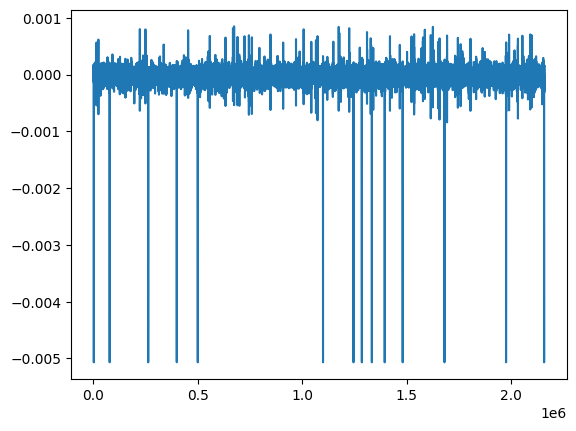

In [602]:
import matplotlib.pyplot as plt

plt.plot(time_series_per_label[label_to_check])

For label 1: Apparently it is correct that label 1 has 2 outliers.

For label 3 & 5: They do not seem to have outliers, which is what we computed.

For label 7: Apparently it is correct that label 1 has 1 outliers.

In [603]:
all_mav = []  # maximal absolute values of all segments

for segment in label_segments[label_to_check]:
    all_mav.append(np.max(np.abs(segment)))

num_outliers = len(outlier_indices[label_to_check])
idx = np.argpartition(all_mav, -num_outliers)
print(idx[-num_outliers:])

[   0  988  840  740  697  666  642  622  549  249  199  131   38 1079]


For both label 1 and 7, the indices of the outliers found by both methods are exactly the same.

### Relabel outliers as 7

In [604]:
def handle_outliers(train_indices_dict, validation_indices_dict, test_indices_dict, all_indices_dict, outliers_indices_in_complete_data, label_list, num_outliers):
    if num_outliers > 0:
        for label in label_list:
            for idx in outliers_indices_in_complete_data[label]:

                for fold_idx in range(5):

                    # Convert to NumPy arrays for easier manipulation
                    all_indices_label = np.array(all_indices_dict["Label_"+str(label)])
                    all_indices_dict["Label_"+str(label)] = all_indices_label[~(all_indices_label == idx)]
                    all_indices_dict["Label_"+str(7)] = np.append(all_indices_dict["Label_"+str(7)], idx)

                    if idx in train_indices_dict["Label_"+str(label)]["Fold_"+str(fold_idx)]:
                        train_indices_label = np.array(train_indices_dict["Label_"+str(label)]["Fold_"+str(fold_idx)])
                        
                        # Use boolean indexing to remove elements
                        train_indices_dict["Label_"+str(label)]["Fold_"+str(fold_idx)] = train_indices_label[~(train_indices_label == idx)]
                        train_indices_dict["Label_"+str(7)]["Fold_"+str(fold_idx)] = np.append(train_indices_dict["Label_"+str(7)]["Fold_"+str(fold_idx)], idx)

                    elif idx in validation_indices_dict["Label_"+str(label)]["Fold_"+str(fold_idx)]:
                        validation_indices_label = np.array(validation_indices_dict["Label_"+str(label)]["Fold_"+str(fold_idx)])

                        validation_indices_dict["Label_"+str(label)] = validation_indices_label[~(validation_indices_label == idx)]
                        validation_indices_dict["Label_"+str(7)]["Fold_"+str(fold_idx)] = np.append(validation_indices_dict["Label_"+str(7)]["Fold_"+str(fold_idx)], idx)

                    elif idx in test_indices_dict["Label_"+str(label)]:
                        test_indices_label = np.array(test_indices_dict["Label_"+str(label)])

                        test_indices_dict["Label_"+str(label)] = test_indices_label[~(test_indices_label == idx)]
                        test_indices_dict["Label_"+str(7)] = np.append(test_indices_dict["Label_"+str(7)], idx)


    return train_indices_dict, validation_indices_dict, test_indices_dict, all_indices_dict

# Call the function with your specific dictionaries and values
train_indices_dict_for_folds, validation_indices_dict_for_folds, test_indices_dict, all_indices_dict = handle_outliers(train_indices_dict_for_folds, validation_indices_dict_for_folds, test_indices_dict, all_indices_dict, outliers_indices_in_complete_data, label_list, num_outliers)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
# Save all indices

# Train indices
np.save("Train_Test_Splitting/"+str(subject)+"/Train_Indices_All_Labels_All_Folds.npy",\
    np.array(train_indices_dict_for_folds, dtype=object), allow_pickle=True)

# Validation indices
np.save("Train_Test_Splitting/"+str(subject)+"/Validation_Indices_All_Labels_All_Folds.npy",\
    np.array(validation_indices_dict_for_folds, dtype=object), allow_pickle=True)

# Final Test set indices
np.save("Train_Test_Splitting/"+str(subject)+"/Final_Test_Set_Indices_All_Labels.npy",\
    np.array(test_indices_dict, dtype=object), allow_pickle=True)



# Persistence Diagrams

## Finding the optimal embedding dimension and time delay

There are two techniques that can be used to determine these parameters automatically:
- Mutual information to determine the time delay
- False nearest neighbours to determine the embedding dimension

In [ ]:
# Initialise the embedding
max_embedding_dimension = 30
max_time_delay = 30
stride = 10

embedder = SingleTakensEmbedding(
    parameters_type="search",
    time_delay=max_time_delay,
    dimension=max_embedding_dimension,
    stride=stride,
)

In [ ]:
def find_optimal_parameters(embedder, segments, max_index, iterations = 8):
    """
    Finds (approximate) optimal embedding parameters by averaging optimal parameters of random segments.

    Parameters:
    - embedder (object): defined by SingleTakensEmbedding() or similar
    - segments (list of lists): Complete EEG/EMG segments
    - max_index (int): How many segments there are
    - iteratiors (int): How many random indices to sample

    Returns:
    Tuple of two floats:
    - Average optimal embedding dimension
    - Average optimal time delay
    """


    optimal_embeddings_dimensions = []
    optimal_time_delays = []
    
    for _ in range(iterations):
        random_index = random.randint(0, max_index)
        embedding = embedder.fit_transform(segments[random_index])
        
         # append optimal embedding dimension for this segment
        optimal_embeddings_dimensions.append(embedder.dimension_)

        # append optimal time delay for this segment
        optimal_time_delays.append(embedder.time_delay_)

        print("The optimal embedding dimension is " + str(np.mean(optimal_embeddings_dimensions)) + 
              " and the optimal time delay is " + str(np.mean(optimal_time_delays)))
        
        return int(np.mean(optimal_embeddings_dimensions)), int(np.mean(optimal_time_delays))

In [ ]:
# Compute optimal embedding parameters

all_segments = []

for label in label_list:
    all_segments.extend(segments[label])
    
embedding_dimension, embedding_time_delay = find_optimal_parameters(embedder, all_segments, len(all_segments), iterations = 8)

## Creating Persistence Diagrams

In [ ]:
# Setting parameters for point cloud embeddings

#embedding_dimension= 3 # for data exploration

embedder = SingleTakensEmbedding(
    parameters_type="fixed",
    n_jobs=2,
    time_delay=embedding_time_delay, # computed above
    dimension=embedding_dimension, # computed above
    stride=stride,
)

In [ ]:
# We will look at 0, 1 and 2 dimensional holes
homology_dimensions = [0, 1, 2]

# We will use a Vietoris Rips filtrations
persistence = VietorisRipsPersistence(
    homology_dimensions=homology_dimensions, n_jobs=10
)

### Computing Points Clouds and Persistence Diagrams

In [ ]:
def compute_embeddings_and_diagrams(segments, time_delay_embeddings, persistence_diagrams, all_indices_dict, label):

    time_delay_embeddings["Label_"+str(label)] = []
    persistence_diagrams["Label_"+str(label)] = []

    # Compute embeddings and diagrams for the complete data
    for diagram_idx in range(len(segments[label])):
        time_delay_embeddings["Label_"+str(label)].append(embedder.fit_transform(segments[label][diagram_idx])[None, :, :])
        persistence_diagrams["Label_"+str(label)].append(persistence.fit_transform(time_delay_embeddings["Label_"+str(label)][diagram_idx]))
    
    return time_delay_embeddings, persistence_diagrams

In [ ]:
# Compute embeddings and persistence diagrams for the complete data

time_delay_embeddings = {}
persistence_diagrams = {}

#for label in label_list:
#    time_delay_embeddings, persistence_diagrams = compute_embeddings_and_diagrams(segments, time_delay_embeddings, persistence_diagrams, all_indices_dict, label)

## Save persistence diagrams and embeddings

In [ ]:
# Persistence diagrams
#np.save('Embeddings_and_Persistence_Diagrams/'+str(subject)+'/'+str(data_type)+'/Persistence_Diagrams_All_Labels.npy', \
#            np.array(persistence_diagrams, dtype=object), allow_pickle=True)

# Embeddings
#np.save('Embeddings_and_Persistence_Diagrams/'+str(subject)+'/'+str(data_type)+'/Embeddings_All_Labels'+\
#            '_Embedding_Dim'+str(embedding_dimension)+'.npy', np.array(time_delay_embeddings, dtype=object), allow_pickle=True)